<a href="https://colab.research.google.com/github/KukovecRok/AlexNet_inaccurate_using_NiaPy/blob/main/AlexNetDiplomskaColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predpogoj - mount gDrive - za import

In [1]:
# Nujno potrebno za dostop do datotek iz gDrivea
from google.colab import drive
drive.mount('/content/gdrive') # Preverjanje pristnosti.. 

Mounted at /content/gdrive


In [2]:
# Potrebni importi
import os
import torch
import torch.nn
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F 
import torchvision.utils as utils
import cv2 
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import argparse
import PIL.Image
import pandas as pd
import glob
from pathlib import Path
import time
from numpy import asarray
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt
import numpy
from scipy import stats

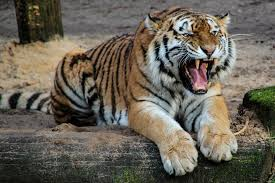

In [3]:
from IPython.display import Image, display
display(Image('/content/gdrive/MyDrive/Colab Notebooks/slike/tiger.jpg')) # Slika iz https://phys.org/news/2019-11-indian-authorities-exaggerated-tiger.html

## Prikaz random slike iz množice

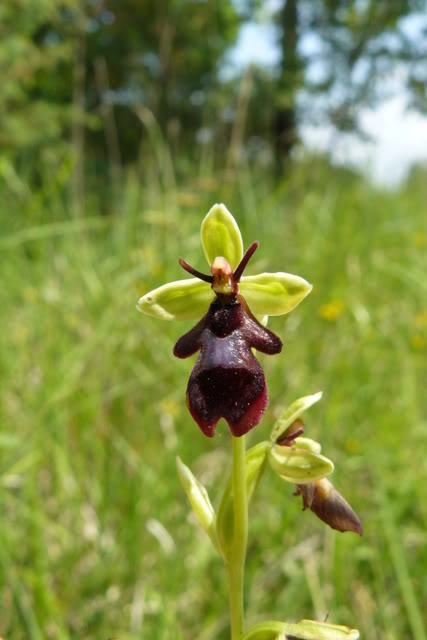

In [4]:
import random, os
# Prikaz nakljucne slike
path = "/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/"
random_file = random.choice([
    x for x in os.listdir(path)
    if os.path.isfile(os.path.join(path, x))
])
Image('/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/'+random_file)

## Funkcija napovejSlike - za import

In [5]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()

def napovejSlike(slika, alexnet):
   # Obdelava velikosti slike
    data_transforms = transforms.Compose([
        transforms.Resize((224,224)),       # Nastavi velikost sičic 224x224
        transforms.ToTensor(),              # Input na Tensorjev format
        transforms.Normalize( # Normalizacija
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )])
    # Odpiranje slik
    transformed_img = data_transforms(slika) # Klicanje funkcije za obdelavo velikosti slik(e)
    batch_img = torch.unsqueeze(transformed_img, 0)
    
    output = alexnet(batch_img)

    sorted, indices = torch.sort(output, descending=True)
    percentage = F.softmax(output, dim=1)[0] * 100.0 
    
    return indices, percentage

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
# Izboljsana napoved - vse slike v mapi
CasZacetek = time.time()

df = None
if df is not None:
    df = df.drop(['SlicicaNo.','Dejansko','Napovedano','PoNiaPy','Tocnost'], axis=1, errors='ignore')

#images = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/slike/*.jpg")
images = glob.glob("/content/gdrive/MyDrive/Colab Notebooks/slike/ILSVRC2010_val/*.JPEG")
podatki = []
for image in images:
   with open(image, 'rb') as file:
        img = PIL.Image.open(file)
        indices, percentage = napovejSlike(img, alexnet)
        i = 0
        with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
            classes = [i.strip() for i in labels.readlines()]

            # Top 5 razredov po verjetnosti napovedi
            results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]

            podatki.append({
                'Slicica No.': (Path(file.name).stem)[20:],
                'Napovedano':  results[0][0],
                'PoNiaPy' : ['Sledi'],
                'Tocnost' : results[0][1],
                'ImeDatoteke' : (Path(file.name).stem + ".JPEG")
            })

            #print("\nTop 5 napovedanih razredov")
            #for i in range(5):
                #print('{}: {:.4f}%'.format(results[i][0], results[i][1]))
            print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')

df = pd.DataFrame(data=podatki)
df.sort_values(by='Tocnost', ascending=False, inplace=True)

CasKonec = time.time()
trajanje = CasKonec - CasZacetek
print("Trajanje: ", trajanje)
# Merjenje časa - CPU 71 sekund ; GPU 301; TPU 338 - nekaj ni ok..


Naš napovedan razred: lifeboat 
Algoritem to trdi z zagotovostvjo 99.94%

Naš napovedan razred: colobus, colobus monkey 
Algoritem to trdi z zagotovostvjo 90.25%

Naš napovedan razred: Staffordshire bullterrier, Staffordshire bull terrier 
Algoritem to trdi z zagotovostvjo 27.14%

Naš napovedan razred: jaguar, panther, Panthera onca, Felis onca 
Algoritem to trdi z zagotovostvjo 39.40%

Naš napovedan razred: tiger, Panthera tigris 
Algoritem to trdi z zagotovostvjo 65.72%

Naš napovedan razred: German short-haired pointer 
Algoritem to trdi z zagotovostvjo 47.54%

Naš napovedan razred: Australian terrier 
Algoritem to trdi z zagotovostvjo 95.59%

Naš napovedan razred: Bouvier des Flandres, Bouviers des Flandres 
Algoritem to trdi z zagotovostvjo 98.80%

Naš napovedan razred: kit fox, Vulpes macrotis 
Algoritem to trdi z zagotovostvjo 77.95%

Naš napovedan razred: English setter 
Algoritem to trdi z zagotovostvjo 92.40%

Naš napovedan razred: red fox, Vulpes vulpes 
Algoritem to trdi z

## Slike iz ILSVRC2010
Model se je na njih izkazal za zelo uspešnega

Tukaj imamo tabelo imen datotek ter kategorij, v katero spadajo

In [ ]:
df1 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/MatLab/ID,Ime,Kategorija.csv", sep=";", index_col=0) 
df1.sample(5) 

,ImeDatoteke,Kategorija
ID_Kategorija,,
390,ILSVRC2010_val_00010672.JPEG,quail
651,ILSVRC2010_val_00013975.JPEG,needle
511,ILSVRC2010_val_00038921.JPEG,harp
499,ILSVRC2010_val_00027279.JPEG,euphonium
682,ILSVRC2010_val_00018064.JPEG,"garbage truck, dustcart"


## Skupne kategorije ILSVRC dataset in AlexNet napovedi
* 634
* Kategorije v preseku, ki jih zna napovedatovat tale AlexNet in slike iz ILSVRC2010
* Validacijska množica ni uporabljena za učenje, rezultati bodo verjetno višji kot pri testni, kar je v mojem primeru tudi smiselno
* Velika točnost pred NiaPy, nato pa nekaj popolnoma drugega za "enako" sliko..

In [ ]:
df2 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/MatLab/BothKategorije.csv", sep=";", index_col=0) 
print(len(df2))

634


## Predpripravljena tabela 
* stolpec NiaPy se bo napolnil kasneje

In [ ]:
# Združevanje za dejanske kategorije
df = df.merge(df1, how='inner', on='ImeDatoteke')
# Brisanje praznih (v df1 je 50.000 vrstic - celotna _val množica slik)
df.dropna(inplace=True)
# Združevanje iz dataframera samo skupnih kategorij --> Inner join odstrani vse primerke, ki jih naš model ne zna napovedat
df = df.merge(df2, how='inner', on='Kategorija')
# Preimenovanje stolpca
df = df.rename(columns={"Kategorija": "Dejanska_kategorija"})
# Zamenjava vrstnega reda stolpcev
df = df[['Slicica No.','Dejanska_kategorija','Napovedano','PoNiaPy','Tocnost','ImeDatoteke']]
df.sort_values(by=['Tocnost'], ascending=False).head(10)
# Dolžina df = 636, kar se sklada s številom različnih imen datotek, katerih kategorije zna napovedat
# V driveu je 1000 slik, vseh kategorij je ~1600, naš AlexNet jih zna napovedat ~2/3 = 1000. 
# Slike so randomly vendar konsistentno poimenovane, ~2/3 * 1000 = ~ 640, torej bo najverjetneje držalo

,Slicica No.,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
0,472,"chambered nautilus, pearly nautilus, nautilus","chambered nautilus, pearly nautilus, nautilus",[Sledi],100.000000,ILSVRC2010_val_00000472.JPEG
2,857,baseball,baseball,[Sledi],99.999985,ILSVRC2010_val_00000857.JPEG
4,041,"odometer, hodometer, mileometer, milometer","odometer, hodometer, mileometer, milometer",[Sledi],99.999763,ILSVRC2010_val_00000041.JPEG
6,733,"maze, labyrinth","maze, labyrinth",[Sledi],99.998917,ILSVRC2010_val_00000733.JPEG
10,116,manhole cover,manhole cover,[Sledi],99.998734,ILSVRC2010_val_00000116.JPEG
13,680,shopping basket,shopping basket,[Sledi],99.998451,ILSVRC2010_val_00000680.JPEG
16,620,"pool table, billiard table, snooker table","pool table, billiard table, snooker table",[Sledi],99.997139,ILSVRC2010_val_00000620.JPEG
19,362,"upright, upright piano","upright, upright piano",[Sledi],99.996796,ILSVRC2010_val_00000362.JPEG
21,990,"giant panda, panda, panda bear, coon bear, Ail...","giant panda, panda, panda bear, coon bear, Ail...",[Sledi],99.995758,ILSVRC2010_val_00000990.JPEG
24,371,"bobsled, bobsleigh, bob","bobsled, bobsleigh, bob",[Sledi],99.994896,ILSVRC2010_val_00000371.JPEG


In [ ]:
col_one_list = df['ImeDatoteke'].tolist()
col_one_list.sort()
# Število različnih imen datotek = 637 - Nekatere kategorije so podvojene (različne slike spadajo v enako kategorijo)
len(col_one_list)

637

## Tabela napačno napovedanih

In [ ]:
dfNapacni = df[~df['Dejanska_kategorija'].isin(df['Napovedano'])]
dfNapacni.sort_values(by=['Tocnost'], ascending=False).head(10)

,Slicica No.,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
262,977,otter,badger,[Sledi],90.782715,ILSVRC2010_val_00000977.JPEG
300,855,"bakery, bakeshop, bakehouse",trifle,[Sledi],87.583496,ILSVRC2010_val_00000855.JPEG
305,415,trimaran,catamaran,[Sledi],86.632523,ILSVRC2010_val_00000415.JPEG
312,193,screwdriver,nail,[Sledi],85.336349,ILSVRC2010_val_00000193.JPEG
329,704,"green lizard, Lacerta viridis","American chameleon, anole, Anolis carolinensis",[Sledi],82.166023,ILSVRC2010_val_00000704.JPEG
337,155,partridge,"ruffed grouse, partridge, Bonasa umbellus",[Sledi],79.790665,ILSVRC2010_val_00000155.JPEG
343,344,cliff dwelling,"sloth bear, Melursus ursinus, Ursus ursinus",[Sledi],78.339333,ILSVRC2010_val_00000344.JPEG
397,353,"artichoke, globe artichoke",cardoon,[Sledi],70.422058,ILSVRC2010_val_00000353.JPEG
416,975,tiger cat,"tiger, Panthera tigris",[Sledi],65.720955,ILSVRC2010_val_00000975.JPEG
263,728,otter,"red-backed sandpiper, dunlin, Erolia alpina",[Sledi],65.469482,ILSVRC2010_val_00000728.JPEG


## Tabela pravilno napovedanih

In [ ]:
dfPravilni = df[df['Dejanska_kategorija'].isin(df['Napovedano'])] #dfPravilni = df.loc[df['Dejanska_kategorija'] == df['Napovedano']] # Drugačna sintaksa za isto stvar
dfPravilni.sort_values(by=['Tocnost'], ascending=False).head(10)

,Slicica No.,Dejanska_kategorija,Napovedano,PoNiaPy,Tocnost,ImeDatoteke
0,472,"chambered nautilus, pearly nautilus, nautilus","chambered nautilus, pearly nautilus, nautilus",[Sledi],100.000000,ILSVRC2010_val_00000472.JPEG
2,857,baseball,baseball,[Sledi],99.999985,ILSVRC2010_val_00000857.JPEG
4,041,"odometer, hodometer, mileometer, milometer","odometer, hodometer, mileometer, milometer",[Sledi],99.999763,ILSVRC2010_val_00000041.JPEG
6,733,"maze, labyrinth","maze, labyrinth",[Sledi],99.998917,ILSVRC2010_val_00000733.JPEG
10,116,manhole cover,manhole cover,[Sledi],99.998734,ILSVRC2010_val_00000116.JPEG
13,680,shopping basket,shopping basket,[Sledi],99.998451,ILSVRC2010_val_00000680.JPEG
16,620,"pool table, billiard table, snooker table","pool table, billiard table, snooker table",[Sledi],99.997139,ILSVRC2010_val_00000620.JPEG
19,362,"upright, upright piano","upright, upright piano",[Sledi],99.996796,ILSVRC2010_val_00000362.JPEG
21,990,"giant panda, panda, panda bear, coon bear, Ail...","giant panda, panda, panda bear, coon bear, Ail...",[Sledi],99.995758,ILSVRC2010_val_00000990.JPEG
24,371,"bobsled, bobsleigh, bob","bobsled, bobsleigh, bob",[Sledi],99.994896,ILSVRC2010_val_00000371.JPEG


## Statistika nad ILSVRC2010_val_\*\*\*\*****.JPEG

In [ ]:
pravilno_napovedani = len(df.index) - len(dfNapacni.index)
print("Vsi napovedani: " + str(len(df.index)) + "\nPravilno napovedani: " + str(pravilno_napovedani) +"\nNapacno napovedani: " + str(len(dfNapacni.index)))
Tocnost = (pravilno_napovedani / len(df.index)* 100)
print("Tocnost: %.4f"% Tocnost+"%")

Vsi napovedani: 637
Pravilno napovedani: 535
Napacno napovedani: 102
Tocnost: 83.9874%


In [ ]:
# Napoved 1 slike
slika = 'strawberries100-53.jpg'
with open('/content/gdrive/MyDrive/Colab Notebooks/slike/'+slika, 'rb') as file:
    img = PIL.Image.open(file)
    indices, percentage = napovejSlike(img, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
            classes = [i.strip() for i in labels.readlines()]

            # Top 5 razredov po verjetnosti napovedi
            results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
            print('\nNaš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')


Naš napovedan razred: strawberry 
Algoritem to trdi z zagotovostvjo 99.99%


# NiaPy - za import
* install

In [6]:
!pip install NiaPy==2.0.0rc12
!pip install -U scikit-image

     |████████████████████████████████| 225kB 5.5MB/s 
     |████████████████████████████████| 829kB 22.2MB/s 
     |████████████████████████████████| 174kB 30.9MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=ef03fe4e8f2bbf170fccbe7342452091e78a665d5ca616f0863e97f599cc7651
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for openpyxl: filename=openpyxl-3.0.3-py2.py3-none-any.whl size=241261 sha256=4bd0b6030027c3c61ce2628015bf63a8ccd451580385cb63f18b2776275eca98
  Stored in directory: /root/.cache/pip/wheels/b5/85/ca/e768ac132e57e75e645a151f8badac71cc0089e7225dddf76b
Successfully built future openpyxl
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


     |████████████████████████████████| 29.2MB 1.5MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2



Prva ideja je po vzoru TestBenchmark.py, ustvarit array podoben "iskanje = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]"
* Pretvorba slike v 1d array
* Standardizacija (vsaka vrednost v arrayu / 255)
* Izvajanje NiaPy
* Pretvorba napovedanih vredenosti nazaj v vrednosti med 1 - 255 ( * 255)
* Pretvorba 1d arraya v sliko
* Prikaz slike, primerjava..


# Funkcije - za import

In [7]:
import cv2
from google.colab.patches import cv2_imshow

def imgTO1d(img):
    oblika = img.shape
    img = img.reshape(-1)
    testko = np.divide(img, 255) 
    return oblika, testko

def imgFROM1d(testko, oblika):
    testkoDva = numpy.multiply(testko, 255)   # Comment??
    testko = asarray(testko)
    testko = testko.reshape(oblika)
    return testko

def napovedInPrikaz(PIL_image, alexnet):
    indices, percentage = napovejSlike(PIL_image, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]
        results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
        napoved = ('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')
    return napoved

def napovedString(PIL_image, alexnet):
    indices, percentage = napovejSlike(PIL_image, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]
        results = [(classes[i], percentage[i].item()) for i in indices[0][:5]]
        napoved = str(results[0][0])
    return napoved

def fitness_NiaPy(iskanjeSlika, napovedan_array_iz_petdeset, alexnet, oblika, dejanska_kategorija, meja): # Fitness Funkcija, ki kliče moj Benchmark, ker lahko prejme samo 2 parametra
    fitness = fitness_default_absolute_benchmark_NiaPy(iskanjeSlika, napovedan_array_iz_petdeset)
    global stevec # global, da jo lahko spreminjam
    stevec += 1 # stevec iteracij

    if ( stevec > meja ):
      fitness *= BenchMark_NiaPy(napovedan_array_iz_petdeset, alexnet, oblika, dejanska_kategorija) # Vrne fitness_alexnet_top_other float - prepricanost alexneta v top nepravinlo napoved

    if ((stevec % 1000) == 0 ): # Vsakih 100 rund izpis
        print("Nova runda: " + str(stevec) + " Koncen fitness: " + str(fitness))

    return fitness

def BenchMark_NiaPy (napovedan_array_iz_petdeset, alexnet, oblika, dejanska_kategorija):
    fitness_alexnet_top_other = 1 # Fuzzy - top = 1, mnozenje z 1 prav tako ničesar ne spremeni, inicializacija

    solutionSpremenjen = imgFROM1d(napovedan_array_iz_petdeset, oblika) # Pretvorba iz 1d v array z obliko slike ( visina*sirina*depth)
    PIL_image_solution = PIL.Image.fromarray(np.uint8(solutionSpremenjen)).convert('RGB') # Pretvorba v PIL sliko, za AlexNet
    # Napoved AlexNet
    indices, percentage = napovejSlike(PIL_image_solution, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]
        results = [(classes[i], percentage[i].item()) for i in indices[0][:2]] # POZOR - zaradi hitrosti shranimo samo top DVE napovedi
        napoved = ('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')
        
    # Top other - prisili napoved v prvo kategorijo, ki jo alexnet poda v enotskem vektorju
    if (str(results[0][0]) != dejanska_kategorija): # Če prva ni pravilno napovedana
      fitness_alexnet_top_other *= ( results[0][1] / 100 )
    else:                                           # Če prva je, sigurno druga ni - if deluje hitreje kot for
      fitness_alexnet_top_other *= ( results[1][1] / 100 )

    if ((stevec % 100) == 0 ):
        print(str(napoved) + " Runda: " + str(stevec) + " Alexnet Fitness: " + str(fitness_alexnet_top_other))

    return fitness_alexnet_top_other

def fitness_default_absolute_benchmark_NiaPy(iskanjeSlika, napovedan_array_iz_petdeset): # Fitness Funkcija, ki kliče moj Benchmark, ker lahko prejme samo 2 parametra
    fitness = 1
    fitness = numpy.sum(numpy.abs(iskanjeSlika-napovedan_array_iz_petdeset)) # Absolutna razlika v pikslih - default BenchMark
    fitness = ( (fitness / len(iskanjeSlika)) ) # Pretvorba vrednost med 0 in 1 po vzoru Fuzzy 
    fitness = (fitness / 255) # delitev z 255
    fitness = ( 1 - (fitness )) # negacija vrednosti
   
    return fitness

# NiaPY 10 pikslov


Spremenili smo: 10.0 pikslov


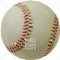

Naš napovedan razred: spotlight, spot 
Algoritem to trdi z zagotovostvjo 23.39%


In [57]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

stevilo_spremenjenih_pikslov = 10

class TestBenchmark(Benchmark):

    def __init__(self, iskanjeSlika, alexnet):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanjeSlika = iskanjeSlika
        self.alexnet = alexnet

    def function(self):
        def evaluate(D, solution):
            global napovedan_array_iz_petdeset
            global benchmarkPrejsnji
            global najboljsiNiaPY
            dejanska_kategorija = "baseball"
            meja = 0 # trenutno tako visoka, da se v B.M. ne vklopi AlexNet, saj niti ne uspem poustvariti originalne slike

            global deset_spremenjenih
            deset_spremenjenih = self.iskanjeSlika

            for i in range( int((D/4)) ):
              if ( i % 4 == 0):
                mesto_v_arrayu = 0
                mesto_v_arrayu = (solution[i] * (len(iskanjeSlika) / 3) )
             
              mesto_v_arrayu = int(mesto_v_arrayu)
              i *= 4
              for j in range(1,4):
                deset_spremenjenih[((mesto_v_arrayu-1)*3 ) + (j-1)] = int((solution[((i+j)%4)] * 255))

            deset_spremenjenih = (numpy.multiply(deset_spremenjenih, 255))
            fitness = fitness_NiaPy(iskanjeSlika, deset_spremenjenih*255, alexnet, oblika, dejanska_kategorija, meja)
            print("Spremenili smo: " + str((D/4)) + " pikslov")

            return fitness
        
        return evaluate

if __name__ == "__main__":

    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol60-60.JPEG') # odpiranje - branje slike

    oblika, iskanjeSlika = imgTO1d(originalSlika) # Pretvorba slike v 1d array + njena oblika (x,y,3)

    algoritem = ParticleSwarmAlgorithm(NP=1000)

    stevec = 0

    benchmarkPrejsnji = 0 # Primerjava BenchMarkov med iteracijami - če je slabši, prepišemo "najboljsiNiaPY" in "benchmarkPrejsnji"

    benchm = TestBenchmark(iskanjeSlika=iskanjeSlika, alexnet=alexnet)
    task = StoppingTask(D=(stevilo_spremenjenih_pikslov*4),
                        nFES=1,
                        optType=OptimizationType.MAXIMIZATION,
                        benchmark=benchm)

    resitev, fitness = algoritem.run(task=task)

    # Prikaz zadnjega outputa NiaPy 
    napovedan_array_iz_petdeset = imgFROM1d(deset_spremenjenih, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(napovedan_array_iz_petdeset) # Prikaz slike
    napovedan_array_iz_petdeset_image = PIL.Image.fromarray(np.uint8(napovedan_array_iz_petdeset)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(napovedan_array_iz_petdeset_image, alexnet)) # Izpis napovedi AlexNet

# !!NiaPy 50 Array
* Trenutno ~[300] (deljivo s 4)
* 1,5mil iteracij 
* Po vseh različnih poskusih, fitness ne preseže ~0.6

Nova runda: 1000 Koncen fitness: 0.5099539991741068
Nova runda: 2000 Koncen fitness: 0.4663211713443548
Nova runda: 3000 Koncen fitness: 0.5128065544591112
Nova runda: 4000 Koncen fitness: 0.5106303957167471
Nova runda: 5000 Koncen fitness: 0.49298765289703395
Nova runda: 6000 Koncen fitness: 0.494600837284805
Nova runda: 7000 Koncen fitness: 0.5073740712261665
Nova runda: 8000 Koncen fitness: 0.5049981474361713
Nova runda: 9000 Koncen fitness: 0.49917136286613406
Nova runda: 10000 Koncen fitness: 0.5085159710652598
Nova runda: 11000 Koncen fitness: 0.49760128583023633
Nova runda: 12000 Koncen fitness: 0.4923595953123442
Nova runda: 13000 Koncen fitness: 0.5095305409600296
Nova runda: 14000 Koncen fitness: 0.5014867145115127
Nova runda: 15000 Koncen fitness: 0.5019566334885442
Nova runda: 16000 Koncen fitness: 0.510589669215544
Nova runda: 17000 Koncen fitness: 0.5105071453999175
Nova runda: 18000 Koncen fitness: 0.5137226664957923
Nova runda: 19000 Koncen fitness: 0.4964071966622525
N

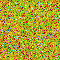

Naš napovedan razred: anemone fish 
Algoritem to trdi z zagotovostvjo 15.85%


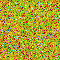

Naš napovedan razred: anemone fish 
Algoritem to trdi z zagotovostvjo 15.85%


In [ ]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanjeSlika, alexnet):
        self.Lower = 0
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanjeSlika = iskanjeSlika
        self.alexnet = alexnet

    def function(self):
        def evaluate(D, solution):
            global napovedan_array_iz_petdeset
            global benchmarkPrejsnji
            global najboljsiNiaPY
            dejanska_kategorija = "baseball"
            meja = 9999999999999999 # trenutno tako visoka, da se v B.M. ne vklopi AlexNet, saj niti ne uspem poustvariti originalne slike

            for i in range( int((D/4)) ):
              if ( i % 4 == 0):
                mesto_v_arrayu = 0
                mesto_v_arrayu = (solution[i] * (len(iskanjeSlika) / 3) )
             
              mesto_v_arrayu = int(mesto_v_arrayu)
              #print("mesto_v_arrayu", mesto_v_arrayu)
              i *= 4
              for j in range(1,4):
                #print("NA MESTU:  " + str( ((mesto_v_arrayu-1)*3 ) + (j-1) ) + "DODALI:  " + str(int((solution[((i+j)%4)] * 255))))
                napovedan_array_iz_petdeset[((mesto_v_arrayu-1)*3 ) + (j-1)] = int((solution[((i+j)%4)] * 255))
                
            fitness = fitness_NiaPy(iskanjeSlika, napovedan_array_iz_petdeset, alexnet, oblika, dejanska_kategorija, meja)

            if (benchmarkPrejsnji < fitness):
                najboljsiNiaPY = napovedan_array_iz_petdeset
                benchmarkPrejsnji = fitness

            return fitness
        
        return evaluate

if __name__ == "__main__":

    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol60-60.JPEG') # odpiranje - branje slike

    oblika, iskanjeSlika = imgTO1d(originalSlika) # Pretvorba slike v 1d array + njena oblika (x,y,3)

    algoritem = ParticleSwarmAlgorithm(NP=1000)
    najboljsiNiaPY = np.empty(len(iskanjeSlika), dtype=object) # Prazen array dolžine iskanega - Malo pomoči NiaPy

    napovedan_array_iz_petdeset = np.empty(len(iskanjeSlika), dtype=object) # Prazen array dolžine iskanega - Malo pomoči NiaPy
    napovedan_array_iz_petdeset = np.full((len(napovedan_array_iz_petdeset)), 0)

    #array_petdeset = np.empty(52, dtype=object) # 52 je deljivo s 4 # Solution

    stevec = 0

    benchmarkPrejsnji = 0 # Primerjava BenchMarkov med iteracijami - če je slabši, prepišemo "najboljsiNiaPY" in "benchmarkPrejsnji"

    benchm = TestBenchmark(iskanjeSlika=iskanjeSlika, alexnet=alexnet)
    task = StoppingTask(D=312,
                        nFES=100000,
                        optType=OptimizationType.MAXIMIZATION,
                        benchmark=benchm)

    resitev, fitness = algoritem.run(task=task)

    # Prikaz najboljsega fitness-benchmark outputa NiaPy 
    resitev = imgFROM1d(najboljsiNiaPY, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(resitev) # Prikaz slike
    resitev_image = PIL.Image.fromarray(np.uint8(resitev)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(resitev_image, alexnet)) # Izpis napovedi AlexNet

    # Prikaz zadnjega outputa NiaPy 
    napovedan_array_iz_petdeset = imgFROM1d(napovedan_array_iz_petdeset, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(napovedan_array_iz_petdeset) # Prikaz slike
    napovedan_array_iz_petdeset_image = PIL.Image.fromarray(np.uint8(napovedan_array_iz_petdeset)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(napovedan_array_iz_petdeset_image, alexnet)) # Izpis napovedi AlexNet

# NiaPy -1 do +1

[0.5 0.5 0.5 ... 0.5 0.5 0.5]
Nova runda: 1000 Koncen fitness: 0.8266893996689634
Nova runda: 2000 Koncen fitness: 0.9272951517616858
Nova runda: 3000 Koncen fitness: 0.9664554261888856
Nova runda: 4000 Koncen fitness: 0.9813267468924841
Nova runda: 5000 Koncen fitness: 0.9875617267532546
Nova runda: 6000 Koncen fitness: 0.9916534414495455
Nova runda: 7000 Koncen fitness: 0.9932246821394763
Nova runda: 8000 Koncen fitness: 0.9949299716632098
Nova runda: 9000 Koncen fitness: 0.995512536922023
Nova runda: 10000 Koncen fitness: 0.9961341432406702
Nova runda: 11000 Koncen fitness: 0.9918909847831119
Nova runda: 12000 Koncen fitness: 0.9856973755190704
Nova runda: 13000 Koncen fitness: 0.9722375197420181
Nova runda: 14000 Koncen fitness: 0.956066758913202
Nova runda: 15000 Koncen fitness: 0.9324460473374734
Nova runda: 16000 Koncen fitness: 0.9074504642303282
Nova runda: 17000 Koncen fitness: 0.8756548367130146
Nova runda: 18000 Koncen fitness: 0.8445085753572762
Nova runda: 19000 Koncen fi

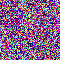

Naš napovedan razred: matchstick 
Algoritem to trdi z zagotovostvjo 8.02%


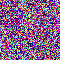

Naš napovedan razred: matchstick 
Algoritem to trdi z zagotovostvjo 8.02%


In [ ]:
from NiaPy.algorithms.basic.pso import ParticleSwarmAlgorithm
from NiaPy.benchmarks import Benchmark
from NiaPy.task.task import OptimizationType, StoppingTask

class TestBenchmark(Benchmark):

    def __init__(self, iskanjeSlika, alexnet):
        self.Lower = -1
        self.Upper = 1
        super().__init__(self.Lower, self.Upper)

        self.iskanjeSlika = iskanjeSlika
        self.alexnet = alexnet

    def function(self):
        def evaluate(D, solution):
            global napovedan_array_iz_petdeset
            global benchmarkPrejsnji
            global najboljsiNiaPY
            dejanska_kategorija = "baseball"
            meja = 9999999999999999 # trenutno tako visoka, da se v B.M. ne vklopi AlexNet, saj niti ne uspem poustvariti originalne slike
            cuvaj = 0.0

            for i in range( int((D/4)) ):
              if ( i % 4 == 0):
                mesto_v_arrayu = 0
                mesto_v_arrayu = abs((solution[i] * (len(iskanjeSlika) / 3) ))
             
              mesto_v_arrayu = int(mesto_v_arrayu)
              #print("mesto_v_arrayu", mesto_v_arrayu)
              i *= 4
              for j in range(1,4):
                cuvaj = ((napovedan_array_iz_petdeset[((mesto_v_arrayu-1)*3 ) + (j-1)]) * (1 + (solution[((i+j)%4)])))
                #print("NA MESTU:  " + str( ((mesto_v_arrayu-1)*3 ) + (j-1) ) + "DODALI:  " + str(int((solution[((i+j)%4)]))) + " CUVAJ : " + str(cuvaj))
                if ( (cuvaj > 0) & (cuvaj < 1) ):
                  napovedan_array_iz_petdeset[((mesto_v_arrayu-1)*3 ) + (j-1)] = cuvaj

            napovedan_array_iz_petdeset_za_benchmark = (numpy.multiply(napovedan_array_iz_petdeset, 255))
            fitness = fitness_NiaPy(iskanjeSlika, napovedan_array_iz_petdeset_za_benchmark, alexnet, oblika, dejanska_kategorija, meja)

            if (benchmarkPrejsnji < fitness):
                najboljsiNiaPY = napovedan_array_iz_petdeset
                benchmarkPrejsnji = fitness

            return fitness
        
        return evaluate

if __name__ == "__main__":

    originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/bejzbol60-60.JPEG') # odpiranje - branje slike

    oblika, iskanjeSlika = imgTO1d(originalSlika) # Pretvorba slike v 1d array + njena oblika (x,y,3)

    algoritem = ParticleSwarmAlgorithm(NP=10000)
    najboljsiNiaPY = np.empty(len(iskanjeSlika), dtype=object) # Prazen array dolžine iskanega - Malo pomoči NiaPy

    napovedan_array_iz_petdeset = np.empty(len(iskanjeSlika), dtype=object) # Prazen array dolžine iskanega - Malo pomoči NiaPy
    napovedan_array_iz_petdeset = np.full((len(napovedan_array_iz_petdeset)), 0.5)

    stevec = 0

    benchmarkPrejsnji = 0 # Primerjava BenchMarkov med iteracijami - če je slabši, prepišemo "najboljsiNiaPY" in "benchmarkPrejsnji"

    benchm = TestBenchmark(iskanjeSlika=iskanjeSlika, alexnet=alexnet)
    task = StoppingTask(D=312,
                        nFES=2000000,
                        optType=OptimizationType.MAXIMIZATION,
                        benchmark=benchm)

    resitev, fitness = algoritem.run(task=task)

    # Prikaz najboljsega fitness-benchmark outputa NiaPy 
    resitev = imgFROM1d(najboljsiNiaPY, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(resitev*255) # Prikaz slike
    resitev_image = PIL.Image.fromarray(np.uint8(resitev)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(resitev_image, alexnet)) # Izpis napovedi AlexNet

    # Prikaz zadnjega outputa NiaPy 
    napovedan_array_iz_petdeset = imgFROM1d(napovedan_array_iz_petdeset, oblika) # Pretvorba nazaj v sliko
    cv2_imshow(napovedan_array_iz_petdeset*255) # Prikaz slike
    napovedan_array_iz_petdeset_image = PIL.Image.fromarray(np.uint8(napovedan_array_iz_petdeset)).convert('RGB') # Pretvorba v PIL format - za AlexNet
    print(napovedInPrikaz(napovedan_array_iz_petdeset_image, alexnet)) # Izpis napovedi AlexNet

# Funkcije - metrike kakovosti slike - za import

In [ ]:
def MSE(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def compare_images(imageA, imageB):
    # compute the mean squared error and structural similarity
    # index for the images
    m = MSE(imageA, imageB)
    s = ssim(imageA, imageB, multichannel=True)
    # setup the figure
    fig = plt.figure(" ")
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
    # show the images
    plt.show()

def PSNR(original, recreated): 
    mse = np.mean((original - recreated) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

# Pygad - za import

In [ ]:
!pip install pygad

     |████████████████████████████████| 51kB 2.9MB/s 


# PyGad Funkcije - za import

In [ ]:
import pygad

import itertools
import functools
import operator
import random

def imgTO1dGari(img):
    oblika = img.shape # Shramba shapea slike v "oblika"
    #img = img.reshape((1, -1)) # Pretvorba v 1d array
    img = img.reshape(-1)
    img = np.divide(img, 255) # Standardizacija - deljenje z 255
    img = img.astype(numpy.float) # pretvorba v float (manj decimalk(8), bistveno hitreje deluje)
    return oblika, img

def imgFROM1dGari(img, oblika):
    img = asarray(img) # Pretvorba v pravilen type
    img = img.reshape(oblika) # pretvorba nazaj v prvotno obliko
    # Pri PyGad ne množimo nazaj z 255, saj plt.imshow(result) prikazuje vrednosti pikslov med 0-1
    return img

def fitness_fun(solution, solution_idx): # Fitness Funkcija, ki kliče moj Benchmark, ker lahko prejme samo 2 parametra
    fitness = fitness_default_absolute_benchmark(solution)
    #fitness = fitness_RMS(solution)
    #fitness = fitness_SSIM(solution)
    #fitness = fitness_PearsonCoefCorelation(solution)

    global stevec # global, da jo lahko spreminjam
    global meja # global, da jo lahko spreminjam
    global mejaBool # global, da jo lahko spreminjam

    """
    Ko smo preko meje, za katero mislimo, da bo reprodukcija slike dovolj dobra
    Pogledamo, če je mejaBool False
    Naredimo napoved z AlexNet nad trenutnim solutionom
    Le če je pravilen, ga vključimo v BenchMark
    S tem dosežemo krajšanje časa izvajanja, saj se za vsak sol_per_pop * num_generations nato kliče AlexNet
    """
    if (mejaBool == False): # Ko smo preko meje
      if (stevec > meja):
          solutionSpremenjen = imgFROM1d(solution, oblika) # pretvorba iz 1d array v sliko
          solutionSpremenjen = solutionSpremenjen*255 # Množenje vseh vrednosti med 0-1 z 255
          solutionSpremenjen = solutionSpremenjen[:,:,::-1] # sprememba bgr --> rgb
          PIL_image_solution = PIL.Image.fromarray(np.uint8(solutionSpremenjen)).convert('RGB') # Ustvaritev PIL slike
          napoved = napovedString(PIL_image_solution, alexnet) # Napoved ki vrne samo string kategorije
          print("?VKLOP AlexNet v BenchMark?: " , napoved, stevec , meja )
          if (str(napoved) != dejanska_kategorija): # Ali je napoved nepravilna? Povečaj mejo // pri sol_per_pop=50 je to 50*10 klicev AlexNeta manj
              meja += 10
          if (str(napoved) == dejanska_kategorija): # Ali je napoved pravilna? Izpolni pogoj za vključitev AlexNeta
              mejaBool = True 
    
    if ( (stevec > meja) & (mejaBool == True) ): # Ko smo preko meje in je pogoj izpolnjen, kliči AlexNet BenchMark
      fitness *= BenchMarkGari(solution, solution_idx,alexnet, oblika, dejanska_kategorija) # Vrne fitness_alexnet_top_other float - prepricanost alexneta v top nepravinlo napoved
    
    if (solution_idx == 1): # solution_idx se loopa od 0 do sol_per_pop
      stevec += 1 # Za vsako polno generacijo povecaj stevec
      if ((stevec % 100) == 0 ): # Vsakih 100 rund izpis
          print("Nova runda: " + str(stevec) + " Rezultat: " + str(fitness))

    # Preprečitev padca benchmarka pri vključitvi AlexNeta
    if (mejaBool == False):      
      fitness *= 0.5
    else:
      fitness = (fitness * 0.5) + 0.5

    return fitness

def BenchMarkGari (solution, solution_idx,alexnet, oblika, dejanska_kategorija):
    fitness_alexnet_top_other = 1 # Fuzzy - top = 1, mnozenje z 1 prav tako ničesar ne spremeni, inicializacija

    solutionSpremenjen = imgFROM1dGari(solution, oblika) # Pretvorba iz 1d v array z obliko slike ( visina*sirina*depth)
    solutionSpremenjen = solutionSpremenjen*255
    solutionSpremenjen = solutionSpremenjen[:,:,::-1]
    PIL_image_solution = PIL.Image.fromarray(np.uint8(solutionSpremenjen)).convert('RGB') # Pretvorba v PIL sliko, za AlexNet
    # Napoved AlexNet
    indices, percentage = napovejSlike(PIL_image_solution, alexnet)
    with open('/content/gdrive/MyDrive/Colab Notebooks/class_names_ImageNet.txt') as labels:
        classes = [i.strip() for i in labels.readlines()]
        results = [(classes[i], percentage[i].item()) for i in indices[0][:2]] # POZOR - zaradi hitrosti shranimo samo top DVE napovedi
        napoved = ('Naš napovedan razred: ' + str(results[0][0]) + ' \nAlgoritem to trdi z zagotovostvjo %.2f' %(results[0][1])+'%')
        
    # Top other - prisili napoved v prvo kategorijo, ki jo alexnet poda v enotskem vektorju
    if (str(results[0][0]) != dejanska_kategorija): # Če prva ni pravilno napovedana
      fitness_alexnet_top_other *= ( results[0][1] / 100 )
    else:                                           # Če prva je, sigurno druga ni - if deluje hitreje kot for zanka
      fitness_alexnet_top_other *= ( results[1][1] / 100 )

    if (solution_idx == 20): # Vsake tolko izpis, da lahko spremljamo
        if ((stevec % 10) == 0 ):
            print(str(napoved) + " Runda: " + str(stevec) + " Fitness alexneta: " + str(fitness_alexnet_top_other))

    return fitness_alexnet_top_other
    
# Se je izkazal za najboljšega
def fitness_default_absolute_benchmark(solution): # Fitness Funkcija, ki kliče moj Benchmark, ker lahko prejme samo 2 parametra
    fitness = 1
    fitness = numpy.sum(numpy.abs(iskanjeSlika-solution)) # Absolutna razlika v pikslih - default BenchMark
    fitness = ( (fitness / len(solution)) ) # Pretvorba vrednost med 0 in 1 po vzoru Fuzzy 
    fitness = ( 1 - fitness) # negacija vrednosti
    return fitness

# Primer fitnessa z geometrijskim povprečjem arrayev
def fitness_geometrical_mean (solution):
  fitness = 1
  fitness = np.prod(np.power(numpy.abs(iskanjeSlika-solution), (1/(len(solution)))))
  fitness = ( 1 - fitness) # negacija vrednosti
  return fitness

# Primer fitnessa z RMS
def fitness_RMS (solution):
  fitness = 1
  fitness = numpy.sum(numpy.square(numpy.abs(iskanjeSlika-solution)))
  fitness = ( (fitness / len(solution)) ) # Pretvorba vrednost med 0 in 1 po vzoru Fuzzy 
  fitness = numpy.sqrt(fitness)
  fitness = ( 1 - fitness) # negacija vrednosti
  return fitness

# Primer fitnessa s strukturno podobnostjo 2 slik
def fitness_SSIM (solution):
  fitness = 1
  solution = imgFROM1d(solution, oblika) # Pretvorba nazaj v sliko
  fitness = ssim(originalSlika, solution, multichannel=True)
  return fitness

# Pearson correlation coefficient - Primer fitnessa s Pearsonovim korelacijskim koeficientom
def fitness_PearsonCoefCorelation (solution):
  fitness = 1
  fitness = stats.pearsonr(solution, iskanjeSlika)[0]
  fitness = ( (fitness/2) + 0.5) # (da so vrednosti med 0 in1 namesto med -1 in 1)
  return fitness

# PyGad
* trenutna slika 120*120

Ob spremembi slike potrebno spremeniti dva stringa: "dejanska_kategorija" in "originalSlika"

Nova runda: 100 Rezultat: 0.6479692093600565
Nova runda: 200 Rezultat: 0.6503779364459591
Nova runda: 300 Rezultat: 0.6528645420533439
Nova runda: 400 Rezultat: 0.655276270756088
Nova runda: 500 Rezultat: 0.6576908108171675
Nova runda: 600 Rezultat: 0.6600792005742119
Nova runda: 700 Rezultat: 0.662437519515464
Nova runda: 800 Rezultat: 0.6648197740241542
Nova runda: 900 Rezultat: 0.6670650423338669
Nova runda: 1000 Rezultat: 0.6693948504490788
Nova runda: 1100 Rezultat: 0.6716361711249765
Nova runda: 1200 Rezultat: 0.6738836603574141
Nova runda: 1300 Rezultat: 0.6761525935866768
Nova runda: 1400 Rezultat: 0.6784725771268154
Nova runda: 1500 Rezultat: 0.6807483404797328
Nova runda: 1600 Rezultat: 0.6829397591917744
Nova runda: 1700 Rezultat: 0.685065649880056
Nova runda: 1800 Rezultat: 0.6871388428007339
Nova runda: 1900 Rezultat: 0.6891642333877441
Nova runda: 2000 Rezultat: 0.6912540343443758
Nova runda: 2100 Rezultat: 0.6933385835411403
Nova runda: 2200 Rezultat: 0.6954508590199191


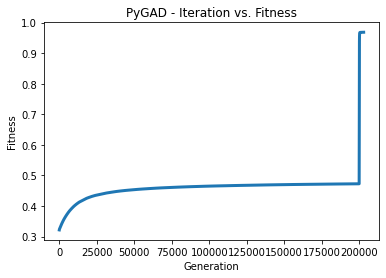

Fitness value of the best solution = 0.9686028077894504
Index of the best solution : 0
Best fitness value reached after 202996 generations.


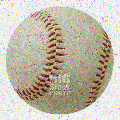

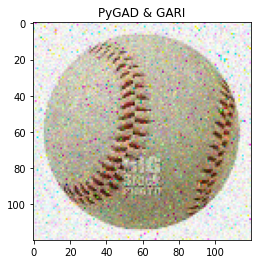

/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


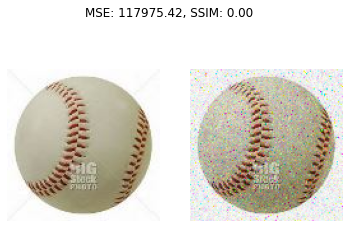

PSNR value is 2.1841 dB
Trajanje izvedbe 12730.160455226898ekund 


In [ ]:
CasZacetek = time.time()

#dejanska_kategorija = "chambered nautilus, pearly nautilus, nautilus" # kaj je dejansko na sliki? # SPREMEMBA SLIKE - SPREMEMBA STRINGA!
dejanska_kategorija = "baseball"
stevec = 0 # Števec rund, pogoji za izpis...
meja = 200000 # Meja, kdaj začnemo preverjat, če AlexNet že prepozna kaj je na sliki
mejaBool = False  # Če Alexnet pravilno napove, nastavimo na True, ga vklopimo v BenchMark

#originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/nautlius80-60.JPEG') # Branje slike # SPREMEMBA SLIKE - SPREMEMBA STRINGA!
originalSlika = cv2.imread('/content/gdrive/MyDrive/Colab Notebooks/slike/baseball-120-120.JPEG') # Branje slike # SPREMEMBA SLIKE - SPREMEMBA STRINGA!

oblika, iskanjeSlika = imgTO1dGari(originalSlika) # Pretvorba slike v 1d array + shramba njene oblike(shape) 

zmnozek_oblika = numpy.prod(oblika)

ga_instance = pygad.GA(num_generations=203000, # nekje med 20 in 30k so slike alexnetu prvic prepoznavne
                       num_parents_mating=20, #20
                       fitness_func=fitness_fun,
                       sol_per_pop=50, #50
                       num_genes=int(zmnozek_oblika), # int64 ne gre, pretvorba z int()
                       init_range_low=0.0,
                       init_range_high=1.0,
                       mutation_percent_genes=0.01, # Mutacija 1 / 2 pikslov (odvisno od velikosti)
                       mutation_type="random",
                       mutation_by_replacement=True,
                       random_mutation_min_val=0.0,
                       random_mutation_max_val=1.0)

ga_instance.run() # Zagon

ga_instance.plot_result() # Izris grafa z matplotlib

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution() # Iz najboljse resitve poberemo array, fitness in njen index
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness)) 
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))

result = imgFROM1dGari(solution, oblika) # Pretvorba nazaj v sliko

cv2_imshow(result*255) # prikaz slike z OpenCV

result = result[:,:,::-1] # Obrni barve BGR  --> RGB 
plt.imshow(result)
plt.title("PyGAD & GARI")
plt.show()

originalSlika = originalSlika[:,:,::-1]
err = compare_images(originalSlika, result)
print(f"PSNR value is %.4f dB" %PSNR(originalSlika, result) ) # resitev odResitev najboljsiNiaPY

CasKonec = time.time()
trajanje = CasKonec - CasZacetek
print("Trajanje izvedbe % sekund " %trajanje) 